In [41]:
%matplotlib inline

import fipy as fp
import fipy.tools.numerix as numerix

In [42]:
nx = 200
ny = 200
dx = 0.25
dy = 0.25
dt = 0.1
mesh = fp.Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)

In [43]:
mm = 4
epsilon_m = 0.0#25
theta_0 = 0.0
tau_0 = 1.
DD = 10.
W_0 = 1.
lamda = DD * tau_0 / 0.6267 / W_0**2
delta = 0.05

In [44]:
phase = fp.CellVariable(mesh=mesh, hasOld=True)
uu = fp.CellVariable(mesh=mesh, hasOld=True)
uu.constrain(-delta, mesh.exteriorFaces)

In [45]:
def initialize():
    phase[:] = -1.0
    x, y = mesh.cellCenters
    radius = 5.0
    center = (nx * dx / 2., ny * dy / 2.)
    mask = (x - center[0])**2 + (y - center[1])**2 < radius**2
    phase.setValue(1., where=mask)
    uu[:] = -delta
    #dt = fp.Variable(0.1)
initialize()

In [46]:
def make_tau(phase_):
    theta_cell = numerix.arctan2(phase_.grad[1], phase_.grad[0])
    a_cell = 1 + epsilon_m * numerix.cos(mm * theta_cell - theta_0)
    return tau_0 * a_cell**2

tau = make_tau(phase)
tau_old = make_tau(phase.old)

In [47]:
source_explicit = 2 * phase**3 - lamda * uu * (1 - phase**2) * (1 + 3 * phase**2)
source_implicit = (1 - 3 * phase**2) + 4 * lamda * uu * phase * (1 - phase**2)
# source = (phase - lamda * uu * (1 - phase**2)) * (1 - phase**2)

In [48]:
theta = numerix.arctan2(phase.faceGrad[1], phase.faceGrad[0])
W = W_0 * (1 + epsilon_m * numerix.cos(mm * theta - theta_0))

W_theta = - W_0 * mm * epsilon_m * numerix.sin(mm * theta - theta_0)

I0 = fp.Variable(value=((1,0), (0,1)))
I1 = fp.Variable(value=((0,-1), (1,0)))

Dphase = W**2 * I0 + W * W_theta * I1

In [49]:
heat_eqn = fp.TransientTerm() == fp.DiffusionTerm(DD) + (phase - phase.old) / dt / 2.
tau = 1.0
phase_eqn = fp.TransientTerm(tau) == fp.DiffusionTerm(Dphase) + source_explicit + \
            fp.ImplicitSourceTerm(source_implicit) #+ fp.ImplicitSourceTerm((tau - tau_old) / dt)

In [50]:
print max(tau), min(tau)

TypeError: 'float' object is not iterable

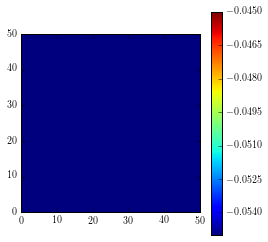

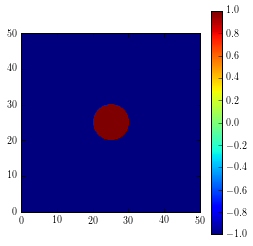

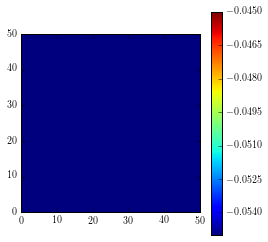

In [51]:
phase_viewer = fp.Viewer(phase)
uu_viewer = fp.Viewer(uu)
phase_viewer.plot()
uu_viewer.plot()

In [52]:
initialize()
#dt.setValue(0.01)
total_steps = 40
sweeps = 5
tolerance = 1e-1
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver_heat = Solver()
solver_phase = Solver()

current_step = 0
while current_step < total_steps:
    uu.updateOld()
    phase.updateOld()

    res_heat0 = heat_eqn.sweep(uu, dt=dt, solver=solver_heat)
    res_phase0 = phase_eqn.sweep(phase, dt=dt, solver=solver_phase)

    for sweep in range(sweeps):
        res_heat = heat_eqn.sweep(uu, dt=dt, solver=solver_heat)
        res_phase = phase_eqn.sweep(phase, dt=dt, solver=solver_phase)

    
    print
    print 'dt',dt  
    print 'current_step',current_step
    print 'res_heat',res_heat0, res_heat
    print 'res_phase',res_phase0, res_phase
#    if (res_heat < res_heat0 * tolerance) and (res_phase < res_phase0 * tolerance):
    current_step += 1
#        dt.setValue(dt.value * 1.1)
#    else:
#        dt.setValue(dt.value * 0.8)
#        uu[:] == uu.old
#        phase[:] = phase.old




dt 0.1
current_step 0
res_heat 0.0 0.000213553269504
res_phase 44.8998886413 6.85918490211e-05

dt 0.1
current_step 1
res_heat 3.38425293197 7.35011356799e-05
res_phase 7.32278044453 3.10823894854e-05

dt 0.1
current_step 2
res_heat 1.32324544042 0.000101417916731
res_phase 2.70604582523 4.88880084704e-05

dt 0.1
current_step 3
res_heat 0.809748785603 0.000301915870383
res_phase 1.66356805671 0.000157856361919

dt 0.1
current_step 4
res_heat 0.587102657242 0.000492838541382
res_phase 1.21933326736 0.000272561249735

dt 0.1
current_step 5
res_heat 0.459655894532 0.000650572036593
res_phase 0.967382483429 0.000374575725587

dt 0.1
current_step 6
res_heat 0.376770422182 0.000772799595993
res_phase 0.803374504175 0.000458457994648

dt 0.1
current_step 7
res_heat 0.318538514859 0.000862463959543
res_phase 0.687273103031 0.000523795034538

dt 0.1
current_step 8
res_heat 0.275291692589 0.000926060059214
res_phase 0.600241672714 0.000573182676436

dt 0.1
current_step 9
res_heat 0.241756065997

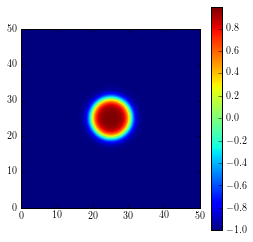

In [53]:
phase_viewer.plot()

In [54]:
max(phase)

0.99373069742389353

In [ ]:
from fipy.tools impor